In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyarrow

## Imports

In [0]:
import os

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import re

from numba import jit
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Here, I start working from the combined `df`.

In [6]:
labels_df = pd.read_feather(f'{PATH_LABELS}/labels_df')

labels_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [7]:
train_df = pd.read_feather(f'{PATH_FEATURES}/train')

# # UNCOMMENT
# test_df = pd.read_feather(f'{PATH_FEATURES}/test')

train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


In [8]:
len(train_df)

16135561

## Outliers
Check for trips are take oddly long or short time.

In [9]:
second_func = ['max', 'count']

new = train_df.groupby('bookingID')['second'].agg(second_func)

new.columns = ["second_" + c for c in new.columns]

new.reset_index(drop=False, inplace=True)

new.head()

,bookingID,second_max,second_count
0,0,1589.0,1004
1,1,1034.0,851
2,2,825.0,195
3,4,1094.0,1094
4,6,1094.0,1095


Before that, we check whether is there any trip that has more sessions recorded than `Second`.

In [10]:
len(new[new['second_max'] < new['second_count']-1])

0

In [11]:
new['second_max'].describe()

count    2.000000e+04
mean     1.995713e+05
std      1.373137e+07
min      1.190000e+02
25%      5.540000e+02
50%      8.540000e+02
75%      1.221000e+03
max      1.495797e+09
Name: second_max, dtype: float64

In [12]:
new['second_max'].quantile(.1)

357.7000000000003

The shortest trip time is ~2 minutes, which is rather unusual. Seeing the 10th percentile is ~6 minutes, I decide to remove trip that takes less than 5 minutes.

In [13]:
new['second_max'].quantile(.999)

3316.1610000006185

The longest trip time is 415,500 hours while the 99.9th percentile is 55 minutes. I will remove anything larger than 55 minutes.

In [14]:
remove = new[(new['second_max'] < 5*60) | 
             (new['second_max'] > 55*60)]['bookingID'].tolist()

len(remove)

1519

1,519 `bookingID`s will be removed.

In [15]:
print('len before remove:', len(train_df))

train_df = train_df[~train_df['bookingID'].isin(remove)]

print('len after remove:', len(train_df))

len before remove: 16135561
len after remove: 15762223


## EDA for some `bookingID`s
I look for 10 `bookingID`s that have a ride time of 10 minutes. From there on, observe the telematics of 3 safe and 3 dangerous trips.

In [0]:
ten_min_ids = new[new['second_count'] >= 10*60].sort_values('second_count')['bookingID'].tolist()

ten_min_ids_10 = ten_min_ids[:10]

In [17]:
labels_df[labels_df['bookingID'].isin(ten_min_ids_10)]

,bookingID,label
4608,231928234021,0
5728,188978561081,0
6063,472446402569,1
6916,34359738406,0
8700,1443109011484,0
10278,807453851710,0
14478,34359738384,1
14957,1099511627918,0
17165,111669149792,0
19467,1425929142350,1


In [0]:
danger0 = '472446402569'
danger1 = '34359738384' 
danger2 = '1425929142350'
safe0 = '111669149792' 
safe1 = '1099511627918'
safe2= '807453851710' 

In [19]:
exclude = ['label', 'bookingID']

features = [c for c in train_df.columns if c not in exclude]

len(features)

10

In [0]:
def feature_plot(id):    
    print(id)
    ex = train_df.query('bookingID == ' + id)
    ex = ex.reset_index(drop=True)
    ex[features].plot(subplots=True, sharex=True, figsize=(12,20))
    plt.show()   

472446402569


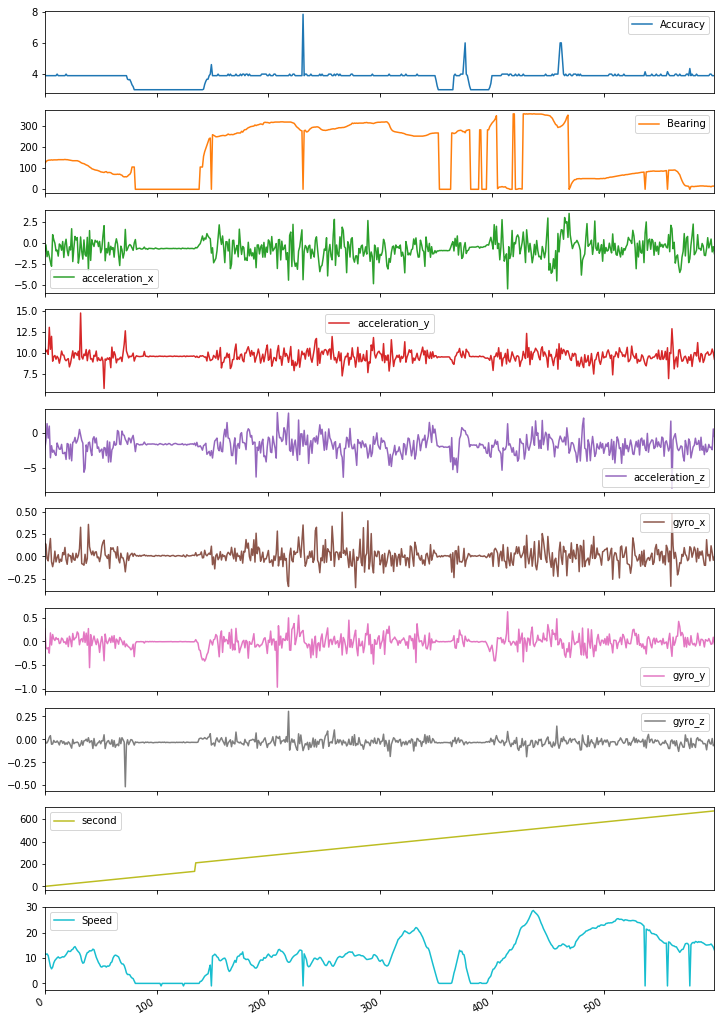

34359738384


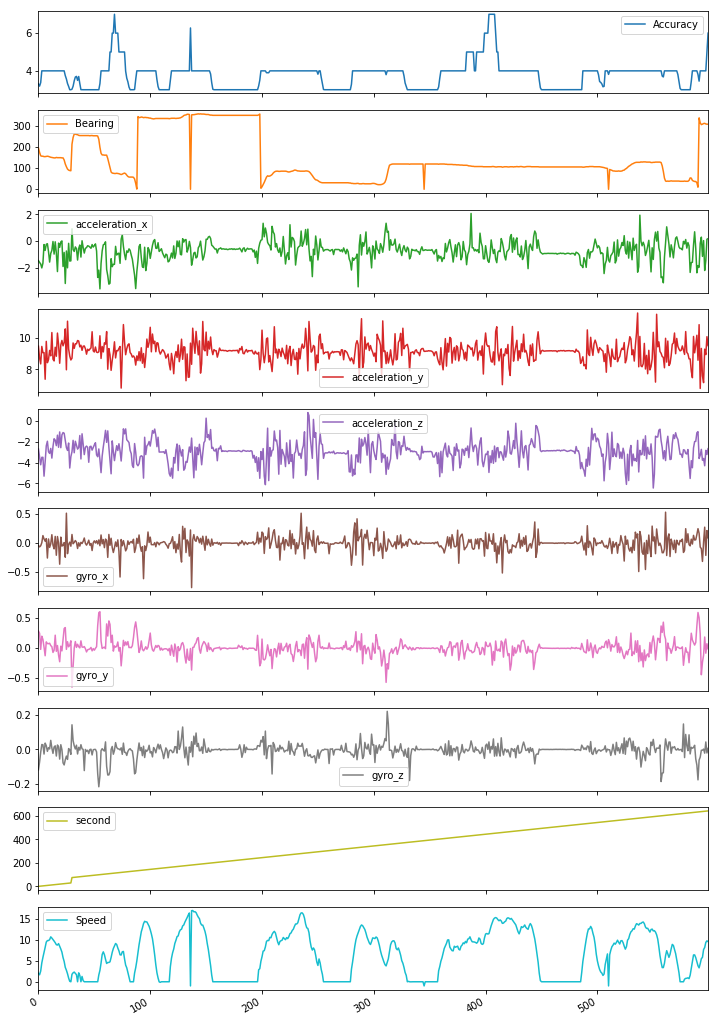

1425929142350


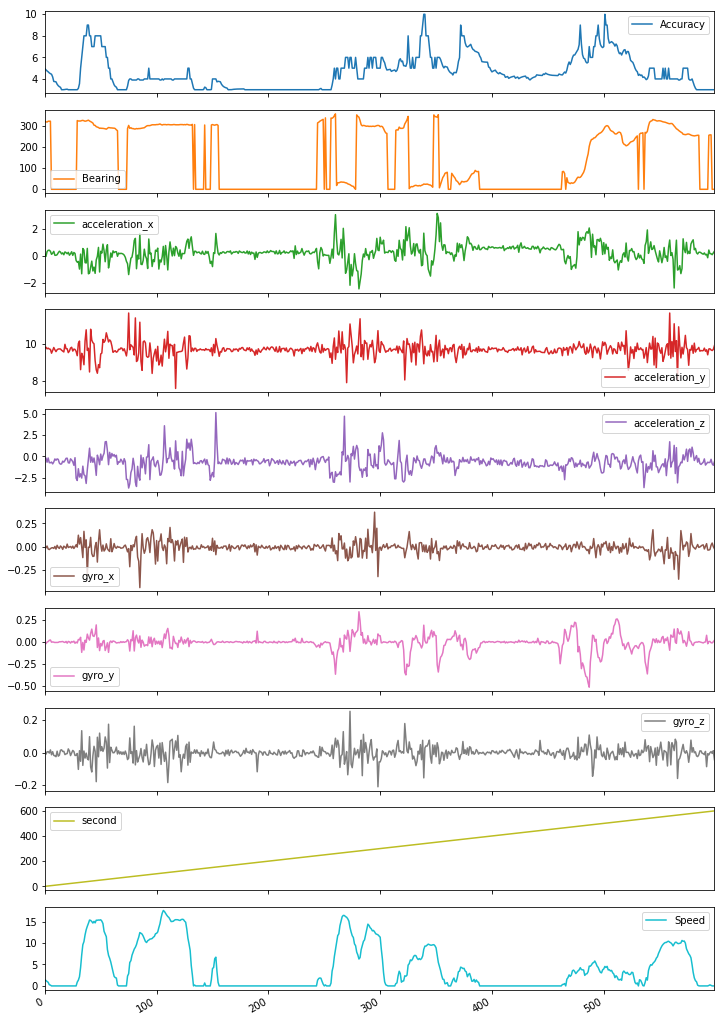

In [21]:
feature_plot(danger0)
feature_plot(danger1)
feature_plot(danger2)

Plots above are by dangerous trips and plots below are for safe trips.

111669149792


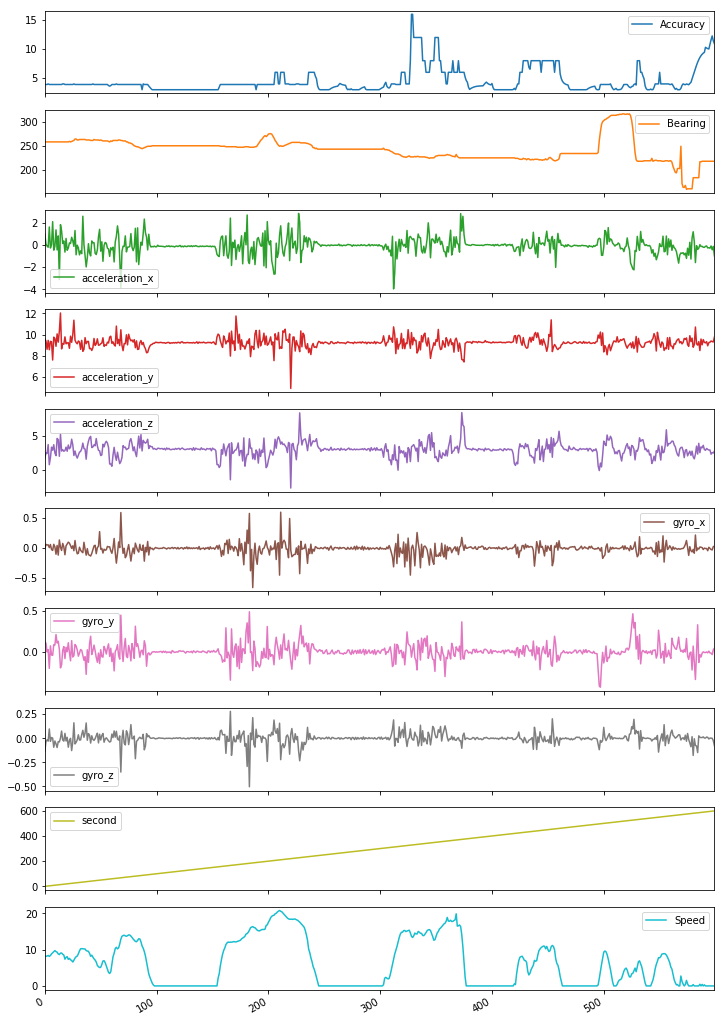

1099511627918


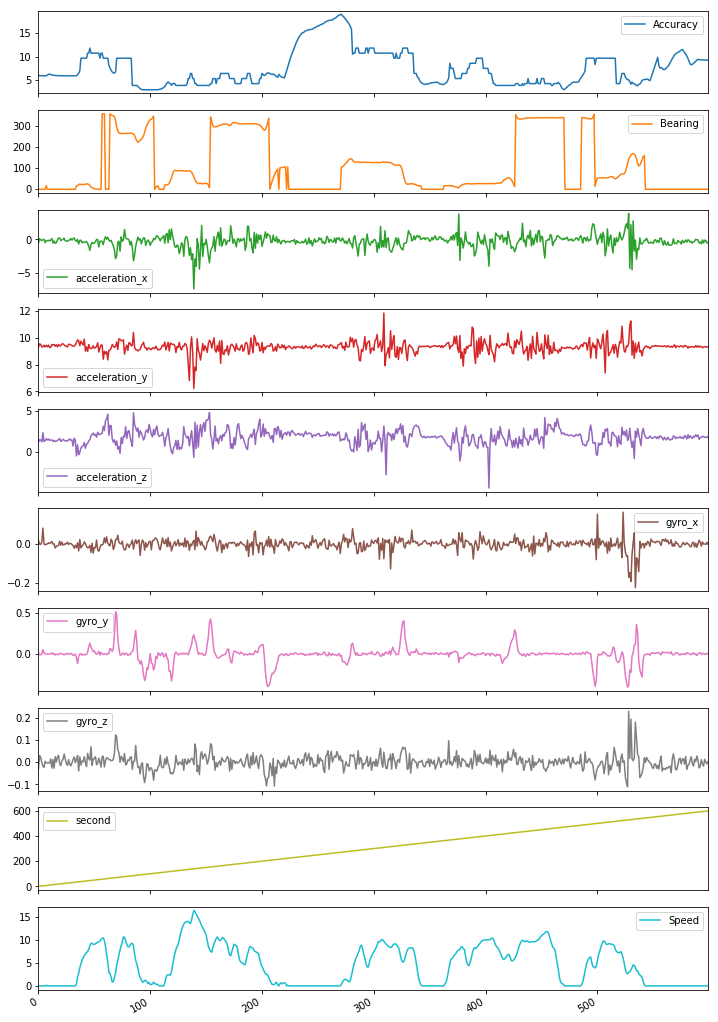

807453851710


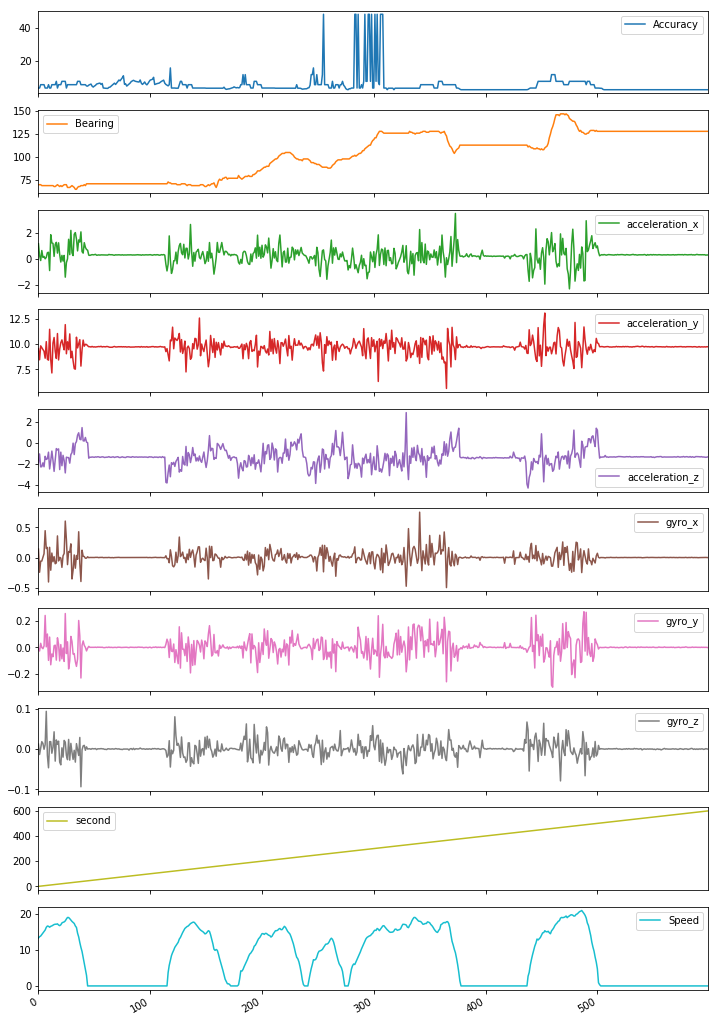

In [22]:
feature_plot(safe0)
feature_plot(safe1)
feature_plot(safe2)

As seen in the plots above, there is nothing starkly different between the telematics of safe and dangerous drivers.

## Feature engineering
Some ideas are taken from this [discussion](https://www.kaggle.com/c/axa-driver-telematics-analysis/discussion/12848#latest-66913) and [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

In [0]:
def total_a(df):
    # acceleration combining all directions
    total_a = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_a'] = np.sqrt(total_a)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
def roll(df):
    # roll  
    yz = df[['acceleration_y', 'acceleration_z']].values
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll'] = np.arctan2(y, z)
    
def roll_gyro(df):
    # roll for gyro 
    yz = df[['gyro_y', 'gyro_z']].values
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll_gyro'] = np.arctan2(y, z)
    
      
def pitch(df):
    # pitch
    xyz = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))

def pitch_gyro(df):
    # pitch
    xyz = df[['gyro_x', 'gyro_y', 'gyro_z']].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch_gyro'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))    
    
def horsepower(df):
    df['horsepower'] = df['total_a'] * df['Speed']
    
def xyz(df):
    df['xy'] = df['acceleration_x'] * df['acceleration_y']
    df['xz'] = df['acceleration_x'] * df['acceleration_z']
    df['yz'] = df['acceleration_y'] * df['acceleration_z']
  
def fe(df):
    total_a(df)
    total_gyro(df)
    roll(df)
    roll_gyro(df)
    pitch(df)
    pitch_gyro(df)
    xyz(df)
    horsepower(df)

In [24]:
%%time
fe(train_df)

# # UNCOMMENT
# fe(test_df)

CPU times: user 10 s, sys: 5 s, total: 15 s
Wall time: 14.9 s


In [25]:
exclude = ['bookingID', 'second', 'Accuracy', 'Bearing']

features = [c for c in train_df.columns if c not in exclude]

len(features)

17

In [26]:
train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,total_a,total_gyro,roll,roll_gyro,pitch,pitch_gyro,xy,xz,yz,horsepower
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,10.176551,0.118788,-1.770774,-0.925921,-0.080479,0.137184,-8.133231,-1.648496,20.032038,35.037767
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,10.059553,0.101508,-1.775202,-1.069841,-0.054344,0.482417,-5.374216,-1.114079,20.054031,2.298150
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,9.503762,0.046282,-1.700522,-1.130342,0.180508,0.676211,15.817892,2.063569,11.212543,2.171177
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,9.830320,0.034511,-1.763290,2.948006,0.144619,0.706854,13.526747,2.636456,17.768669,2.245781
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,9.967466,0.053095,-1.709801,-1.128162,0.060046,0.272633,5.893837,0.824586,13.583822,2.277112


## Aggregate features
In the following, I will get the summary statistical features of all features related to acceleratio and gyro. Since `Accuracy` and `Bearing` are more of a "noise" than useful features, I chose to discard them despite they have been important for my model in various experiments.

In [0]:
# =====================
# differentiation features
# =====================
def fo(x): # first order
    return np.diff(x)

def so(x): # second order
    return np.diff(fo(x))

def fo_min(x):
    # first order diff min
    return abs(np.min(fo(x)))

def so_min(x):
    # second order diff min
    return abs(np.min(so(x)))   

def fo_max(x):
    # first order diff max
    return np.max(fo(x))

def so_max(x):
    # second order diff max
    return np.max(so(x))  

def sign_change(x):
    return sum(np.diff(np.sign(x)) != 0)
  
def percentile(x):
    return np.percentile(x, 90)
  
def count_above_2(x, thres=2):
    return (sum(x >= thres) + sum(x <= -thres))
  
def count_above_3(x, thres=3):
    return (sum(x >= thres) + sum(x <= -thres))    

In [0]:
# =====================
# tsfresh functions
# =====================
def count_above_mean(x):
    m = np.mean(x)
    return np.where(x > m)[0].size

def absolute_sum_of_changes(x):
    return np.sum(np.abs(np.diff(x)))  
  
def kurtosis(x):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    return pd.Series.kurtosis(x)  

def mean_abs_change(x):
    return np.mean(np.abs(np.diff(x)))

In [0]:
def agg_features(df, new_df):
  
    # statistical features
    func = ['max', 'min', 'median', 'std', percentile]
    
    # performed on all features
    features = [c for c in df.columns if c not in exclude]   
    
    for f in features:
        new = df.groupby('bookingID')[f].agg(func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
    
    print('Done statistical features...')
    
    gc.collect()
    
    subfeatures = ['acceleration_x', 'acceleration_y', 'acceleration_z',
                   'gyro_x', 'gyro_y', 'gyro_z',
                   'roll', 'pitch']

    print('Now to tsfresh features...')
    
    # ==================
    # only perform tsfresh
    # features on the 
    # 6 important features
    # ==================
    
    tsfresh_func = [count_above_mean, absolute_sum_of_changes,
                    kurtosis, mean_abs_change]

    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(tsfresh_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
    print('Done tsfresh features...')
    
    gc.collect()
    
    
    # ==================
    # only apply differentiation
    # features on the 
    # 6 important features
    # ==================
        
    print('Now to differentiation features...')
        
   
    diff_func = [fo_min, fo_max,
                 so_min, so_max,
                 sign_change]
        
    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(diff_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
    print('Done differentiation features...')
        
    gc.collect()
    
    # ========================
    # apply threshold=2 and threshold=3
    # for accelerations
    # ========================    
    
    print('Now to threshold for accelerations...')
    
    acc_func = [count_above_2, count_above_3]
    
    accelerations = ['acceleration_x', 'acceleration_y', 'acceleration_z']
    
    for f in accelerations:
        new = df.groupby('bookingID')[f].agg(acc_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
    
    
    print('Done threshold for accelerations...')
    
    gc.collect()
    
    second_func = ['max', 'count']

    new = df.groupby('bookingID')['second'].agg(second_func)

    new.columns = ["second_" + c for c in new.columns]

    new.reset_index(drop=False, inplace=True)

    new_df = pd.merge(new_df, new,
                      left_on='bookingID', right_on='bookingID',
                      how='inner')

    return new_df        

Create a new `df` to hold statistics summary. 

In [30]:
ids = train_df['bookingID'].unique()

agg_train = pd.DataFrame()
agg_train['bookingID'] = ids

print(len(agg_train))

# # UNCOMMENT
# test_ids = test_df['bookingID'].unique()
# agg_test = pd.DataFrame()
# agg_test['bookingID'] = test_ids

18481


In [31]:
%%time
agg_train = agg_features(train_df, agg_train)

# # UNCOMMENT
# agg_test = agg_features(train_df, agg_test)

Done statistical features...
Now to tsfresh features...
Done tsfresh features...
Now to differentiation features...
Done differentiation features...
Now to threshold for accelerations...
Done threshold for accelerations...
CPU times: user 9min 29s, sys: 5.35 s, total: 9min 35s
Wall time: 9min 34s


Merge the aggregated `df` with labels.

In [32]:
agg_train = pd.merge(agg_train, labels_df,
                     left_on='bookingID', right_on='bookingID',
                     how='inner')

agg_train.head()

,bookingID,acceleration_x_max,acceleration_x_min,acceleration_x_median,acceleration_x_std,acceleration_x_percentile,acceleration_y_max,acceleration_y_min,acceleration_y_median,acceleration_y_std,acceleration_y_percentile,acceleration_z_max,acceleration_z_min,acceleration_z_median,acceleration_z_std,acceleration_z_percentile,gyro_x_max,gyro_x_min,gyro_x_median,gyro_x_std,gyro_x_percentile,gyro_y_max,gyro_y_min,gyro_y_median,gyro_y_std,gyro_y_percentile,gyro_z_max,gyro_z_min,gyro_z_median,gyro_z_std,gyro_z_percentile,Speed_max,Speed_min,Speed_median,Speed_std,Speed_percentile,total_a_max,total_a_min,total_a_median,total_a_std,...,acceleration_y_sign_change,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_min,roll_fo_max,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_min,pitch_fo_max,pitch_so_min,pitch_so_max,pitch_sign_change,acceleration_x_count_above_2,acceleration_x_count_above_3,acceleration_y_count_above_2,acceleration_y_count_above_3,acceleration_z_count_above_2,acceleration_z_count_above_3,second_max,second_count,label
0,0,4.782614,-4.692294,-0.725250,0.928022,0.347582,-6.119916,-12.764703,-9.622127,0.639934,-8.936234,2.318857,-6.251807,-1.607663,1.141266,-0.210278,0.438371,-0.392537,0.002575,0.065954,0.083481,0.469724,-0.609930,-0.002239,0.100225,0.097003,0.372807,-0.731892,-0.003522,0.063685,0.061658,22.946083,-1.0,8.503366,7.199919,18.748623,12.988328,6.457339,9.852645,0.624159,...,0.0,5.173502,6.087766,9.125891,10.789780,128.0,0.525470,0.486405,0.972448,0.930134,491.0,0.629634,0.897888,1.315454,1.044398,452.0,0.568942,0.719506,0.698531,1.288449,486.0,0.601279,0.525920,0.929869,1.103402,0.0,0.565893,0.622762,0.912975,1.049871,251.0,77.0,17.0,1004.0,1004.0,309.0,101.0,1589.0,1004,0
1,1,3.813341,-5.352994,-0.563126,0.744157,0.059367,12.536156,6.623425,9.537963,0.533915,10.133488,1.481293,-5.355455,-2.175822,0.854271,-1.213190,0.126536,-0.125367,-0.001518,0.027740,0.029845,0.470837,-0.678183,-0.003491,0.091699,0.070302,0.235131,-0.121265,-0.000384,0.033838,0.040108,21.882141,-1.0,6.904588,7.059362,18.593060,12.790147,6.970526,9.844748,0.519956,...,0.0,4.126713,3.441799,7.568512,5.746438,20.0,0.173800,0.238639,0.403154,0.299289,454.0,0.352295,0.372715,0.388964,0.472042,361.0,0.231692,0.206280,0.340217,0.347914,409.0,0.347471,0.434247,0.486340,0.781718,0.0,0.308782,0.333688,0.397189,0.441969,104.0,32.0,7.0,851.0,851.0,546.0,115.0,1034.0,851,1
2,2,1.956122,-2.971295,0.433364,0.756589,1.145421,13.333716,7.941810,9.814133,0.505693,10.212540,2.312870,-3.282551,0.366324,1.020021,1.235446,0.282162,-0.155218,0.001164,0.053903,0.052843,0.431695,-0.462000,0.001035,0.117321,0.092787,0.255884,-0.125907,0.001764,0.036215,0.032063,9.360483,0.0,2.998761,2.897762,7.260158,13.403410,8.234988,9.877755,0.515173,...,0.0,4.683201,2.942564,5.363175,5.947378,61.0,0.396452,0.300546,0.665232,0.558331,90.0,0.347582,0.301157,0.391565,0.490525,49.0,0.332922,0.290161,0.623083,0.437990,96.0,0.295072,0.479682,0.647632,0.497192,0.0,0.224242,0.336153,0.424833,0.534245,37.0,1.0,0.0,195.0,195.0,9.0,2.0,825.0,195,1
3,4,2.019635,-2.866458,-0.381168,0.527220,0.183690,-7.064984,-18.847833,-9.364999,0.598023,-8.921670,0.296381,-9.374869,-2.608658,0.779529,-1.627701,0.438732,-0.420507,-0.022799,0.042342,0.011330,0.652628,-0.506531,0.024504,0.112567,0.136198,0.505220,-0.348189,-0.001147,0.065927,0.064638,19.780001,0.0,3.310000,5.595901,16.135000,21.053265,7.703982,9.791035,0.620066,...,0.0,7.400095,6.435437,8.689844,13.835532,4.0,0.434474,0.484957,0.894047,0.838916,248.0,0.702851,0.701457,1.298823,1.169583,354.0,0.509004,0.616145,1.086375,0.714633,488.0,0.246631,0.297355,0.461395,0.405312,0.0,0.251567,0.361889,0.568666,0.403067,168.0,12.0,0.0,1094.0,1094.0,908.0,298.0

Save the `df`.

In [0]:
agg_train.to_feather(f'{PATH_FEATURES}/agg_train-5')

# # UNCOMMENT
# agg_test.to_feather(f'{PATH_FEATURES}/agg_test')

## Aggregated features EDA 

In [0]:
# agg_train = pd.read_feather(f'{PATH_FEATURES}/agg_train')

train_df = agg_train.copy()

In [35]:
gc.collect()

42

In [36]:
cols = [c for c in train_df.columns if 'max' in c]

len(cols)

34

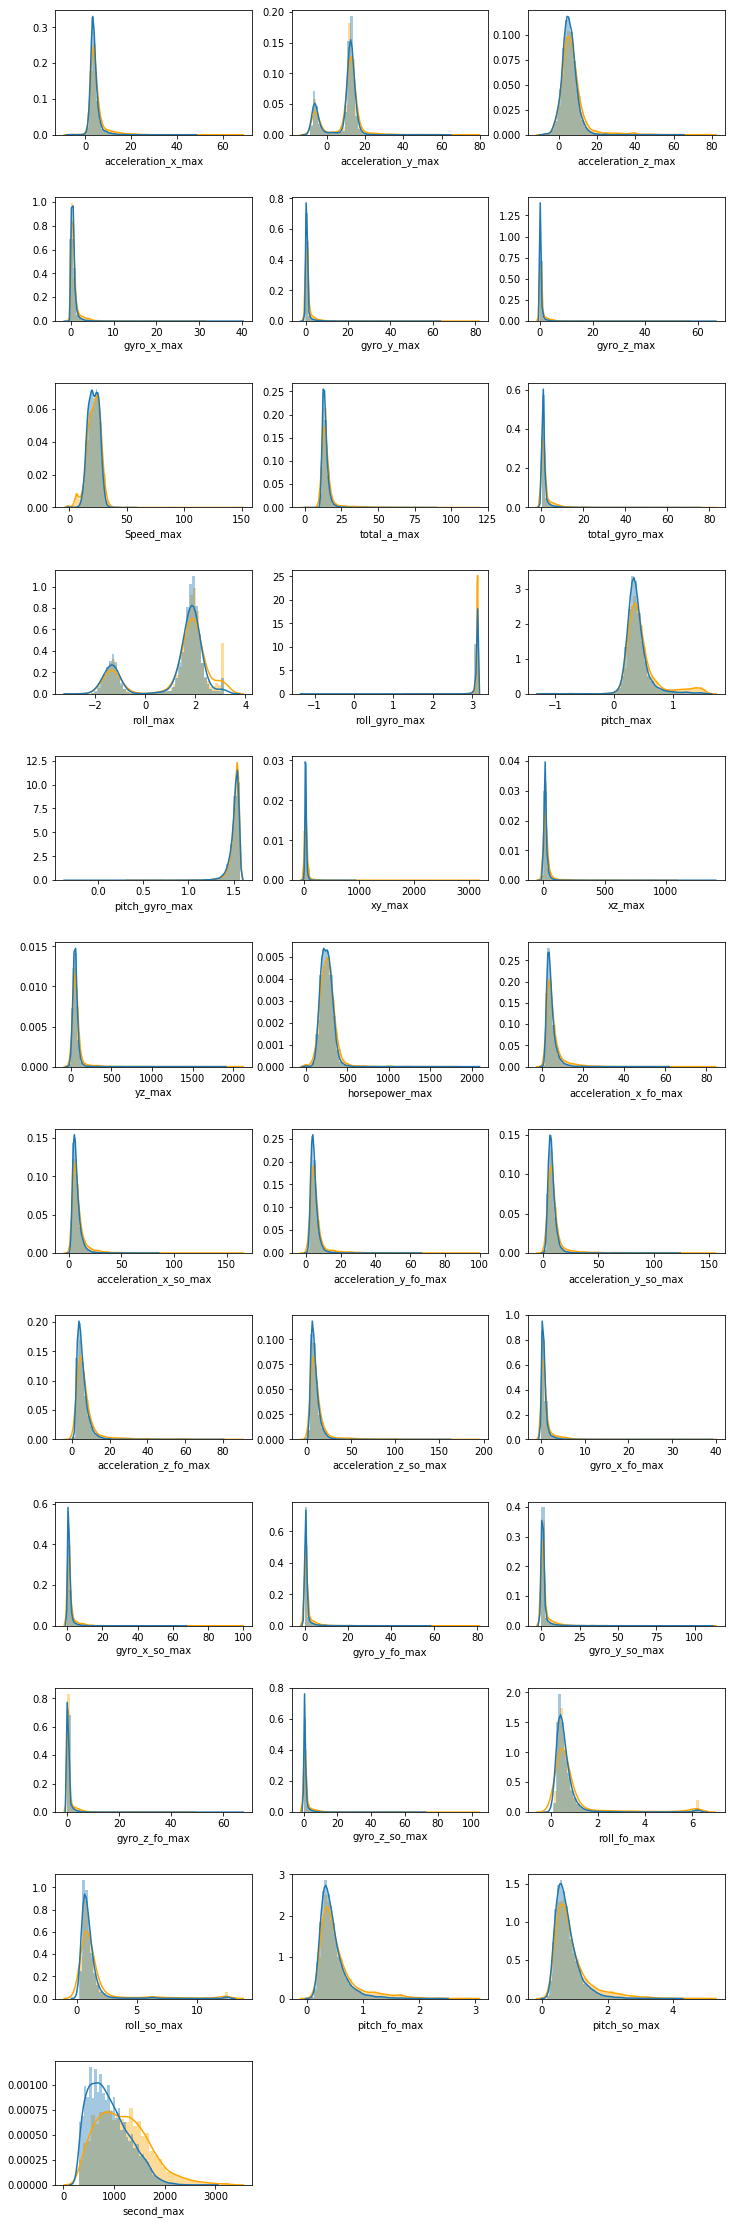

In [37]:
plt.figure(figsize=(12,40))
for i, col in enumerate(cols):
    plt.subplot(12, 3, i+1)
    sns.distplot(train_df[train_df['label']==1][col],color ='orange')
    sns.distplot(train_df[train_df['label']==0][col])
    plt.subplots_adjust(hspace=0.5)
plt.show()

As seen in the plots above,  there happens to be a clear distinction between safe and dangerous drivers for the feature `second_max`. Unfortunately, if Grab plans to assess the safety of a trip, this feature is not going to be useful. In other words, this is a "leaked" feature.

In [0]:
features = [c for c in train_df.columns if c not in ['bookingID', 'label']]

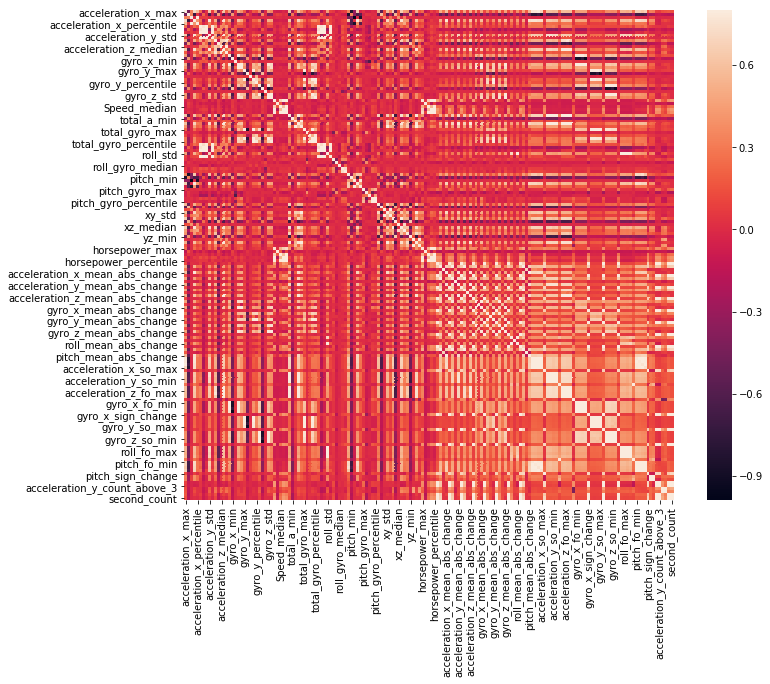

In [39]:
corr_mat = train_df[features].corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

Check for outliers according to Chauvenet's criterion.

In [0]:
from scipy.special import erfc

def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [0]:
train_outliers = dict()

for col in features:
    train_outliers[col] = train_df[chauvenet(train_df[col].values)].shape[0]    

Create a dataframe for outliers.

In [42]:
outliers_df = pd.DataFrame.from_dict(train_outliers,
                                     orient='index')

outliers_df = outliers_df.reset_index()

outliers_df = outliers_df.rename(columns={'index': 'feature',
                                           0: 'num_outliers'})

outliers_df = outliers_df.sort_values('num_outliers', ascending=False)

outliers_df = outliers_df[:50]

outliers_df.head()

,feature,num_outliers
147,roll_fo_min,605
55,pitch_max,598
148,roll_fo_max,596
56,pitch_min,593
150,roll_so_max,540


Plot the `outliers_df`.

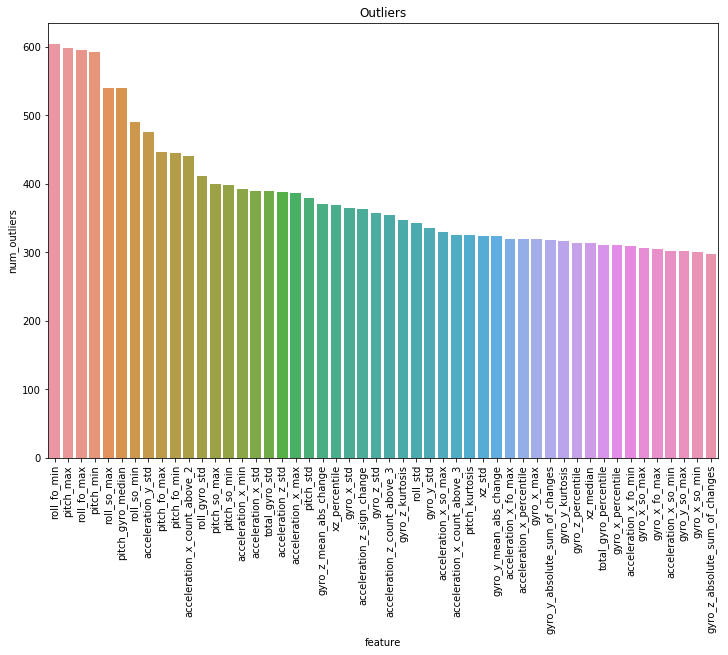

In [43]:
plt.figure(figsize=(12,8))
sns.barplot(x="feature", y="num_outliers", 
            data=outliers_df)
plt.xticks(rotation=90)
plt.title('Outliers')
plt.show()